Loaded model from: tfidf_baseline.joblib
Classes in model: ['negative' 'neutral' 'positive' 'very_negative' 'very_positive']
Using label order: ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
Accuracy: 0.5148  (279/542)

Classification report:
               precision    recall  f1-score   support

very_negative     0.8286    0.3694    0.5110       157
     negative     0.5610    0.3485    0.4299        66
      neutral     0.5682    0.3623    0.4425        69
     positive     0.5690    0.3587    0.4400        92
very_positive     0.4255    0.8917    0.5761       157

    micro avg     0.5148    0.5157    0.5152       541
    macro avg     0.5904    0.4661    0.4799       541
 weighted avg     0.6016    0.5157    0.4992       541

Macro precision: 0.5904
Macro recall   : 0.4661
Macro F1       : 0.4799


/home/dat/llm_ws/.venv310/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dat/llm_ws/.venv310/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dat/llm_ws/.venv310/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.3.2 when using version 

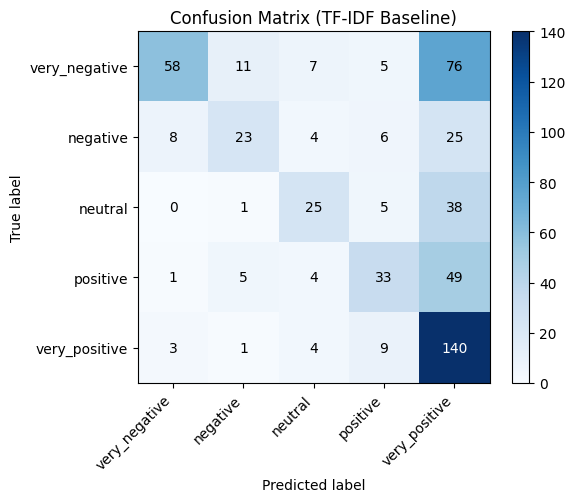

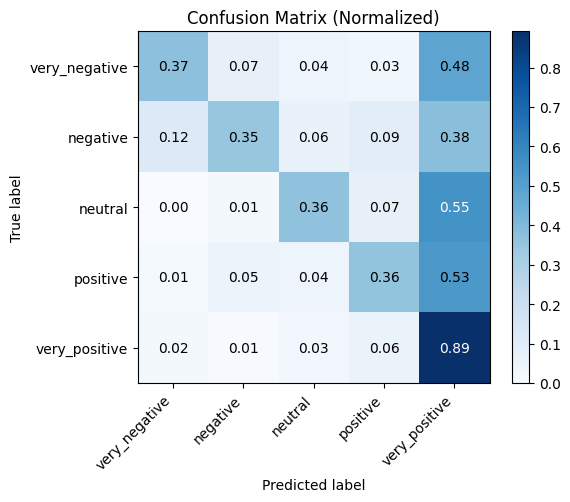

In [1]:
import csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# ========= Khai báo analyzer giống lúc train =========
def analyzer(doc):
    try:
        from underthesea import word_tokenize
        return word_tokenize(str(doc), format="text").split()
    except Exception:
        return str(doc).split()

# ========= Load model =========
MODEL_PATH = Path("tfidf_baseline.joblib")  # đổi path nếu cần
model = load(MODEL_PATH)
print("Loaded model from:", MODEL_PATH)
print("Classes in model:", model.classes_)

# Thứ tự label muốn hiển thị (cột / hàng của confusion matrix)
LABEL_ORDER = ["very_negative", "negative", "neutral", "positive", "very_positive"]
# Lọc lại cho chắc, chỉ giữ những label thực sự có trong model
labels = [lb for lb in LABEL_ORDER if lb in model.classes_]
print("Using label order:", labels)


CSV_PATH = Path("/home/dat/llm_ws/data/test/test.csv")


def eval_tfidf_on_csv(csv_path=CSV_PATH, max_rows=None):
    texts, y_true = [], []

    with csv_path.open("r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if max_rows is not None and i >= max_rows:
                break
            texts.append(row["text"])
            y_true.append(row["label"].strip())

    # Dự đoán
    y_pred = model.predict(texts)

    # ==== Accuracy ====
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}  ({sum(np.array(y_true) == np.array(y_pred))}/{len(y_true)})")

    # ==== Precision / Recall / F1 + report theo từng lớp ====
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            labels=labels,
            target_names=labels,
            digits=4,
            zero_division=0,
        )
    )

    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    macro_prec = prec.mean()
    macro_rec = rec.mean()
    macro_f1 = f1.mean()

    print("Macro precision:", f"{macro_prec:.4f}")
    print("Macro recall   :", f"{macro_rec:.4f}")
    print("Macro F1       :", f"{macro_f1:.4f}")

    # ==== Confusion Matrix (đếm) ====
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix (TF-IDF Baseline)")

    max_val = cm.max() if cm.size > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            text_color = "white" if v > max_val * 0.6 else "black"
            ax.text(j, i, v, ha="center", va="center", color=text_color)

    plt.tight_layout()
    plt.show()

    # ==== Confusion Matrix chuẩn hóa theo hàng (mỗi hàng sum = 1) ====
    cm_norm = cm.astype("float")
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)

    fig2, ax2 = plt.subplots(figsize=(6, 5))

    im2 = ax2.imshow(cm_norm, interpolation="nearest", cmap="Blues")
    plt.colorbar(im2, ax=ax2)

    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_yticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels, rotation=45, ha="right")
    ax2.set_yticklabels(labels)

    ax2.set_xlabel("Predicted label")
    ax2.set_ylabel("True label")
    ax2.set_title("Confusion Matrix (Normalized)")

    max_val_norm = cm_norm.max() if cm_norm.size > 0 else 0
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            v = cm_norm[i, j]
            text_color = "white" if v > max_val_norm * 0.6 else "black"
            ax2.text(j, i, f"{v:.2f}", ha="center", va="center", color=text_color)

    plt.tight_layout()
    plt.show()

    return y_true, y_pred


# ====== Chạy evaluate trên toàn bộ file test ======
y_true_tfidf, y_pred_tfidf = eval_tfidf_on_csv()


In [1]:
import time

# Câu test cố định để đo thời gian
TEST_TEXT = "Mình thấy chất lượng sản phẩm bình thường, không tốt lắm cũng không tệ."

# Số lần lặp để lấy trung bình
N = 10000

# Warm-up (cho chắc model + vectorizer load xong)
_ = model.predict([TEST_TEXT])

t0 = time.time()
for _ in range(N):
    _ = model.predict([TEST_TEXT])
t1 = time.time()

total_time = t1 - t0
avg_time = total_time / N

# Chạy thêm 1 lần để in nhãn cho vui
pred = model.predict([TEST_TEXT])[0]

print("===== TF-IDF baseline (CPU) inference =====")
print("Text test      :", TEST_TEXT)
print("Pred label     :", pred)
print(f"Số lần lặp     : {N}")
print(f"Tổng thời gian : {total_time:.4f} s")
print(f"Thời gian 1 câu: {avg_time*1000:.2f} ms")
print("\n(Ghi chú: TF-IDF + Logistic/SVM sklearn chỉ chạy CPU, không có GPU)")


NameError: name 'model' is not defined